In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)



In [2]:
data = pd.read_csv('./data/rachel_table.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session'])

data_g = pd.read_csv('./data/dan_table.csv')

data['gcamp'] = data_g['gcamp']

# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 


# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)



In [3]:
data_DMS = data[(data['RecordLoc'] == 1) ]
data_Nac = data[(data['RecordLoc'] == 2) ]


In [4]:
# normalize

def normalize(x, mu, std):
    return (x - mu) / std

for data_src, save in zip([data_DMS, data_Nac], [0, 1]):

    for mouse_id in np.unique(data_src['MouseID']):
        mice_gcamp = data_src.loc[data_src['MouseID'] == mouse_id, 'gcamp'].values
        mice_mu = (np.mean(mice_gcamp))
        mice_std = (np.std(mice_gcamp))

        data_src.loc[data_src['MouseID'] == mouse_id, 'gcamp'] = normalize(mice_gcamp, mice_mu, mice_std)

    

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
%%time
# pull out trial by trial info 

data_g = []
data_nac = []

for data_src, save in zip([data_DMS, data_NAC], [data_g, data_nac]):
    dt = 15
    LEN_BEFORE = dt
    LEN_AFTER = dt * 2


    for mouse_id in np.unique(data['MouseID']):
        data_small = data_src[data_src['MouseID'] == mouse_id]


        trial_starts = np.where(data_small['TrialStart'] == 1)[0]


        num_trials = len(trial_starts)
        
        # for stay/leave from last trial
        last_sess = -1

        for t_i, t in enumerate(trial_starts):




            if t_i == (num_trials - 1):
                trial_end = len(data_small)
            else:
                trial_end = trial_starts[t_i + 1]

            data_trial = data_small[t:trial_end];

            # get gcamp after nose poke enter and before lever press 
            npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
            lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]


            # check choice and record time between lever and choice 
            if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
                action = 'Ips'
                choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
            else:
                action = 'Con'
                choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]


            # check if mice is rewarded 
            if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
                reward = 1
                reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
                reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            else:
                reward = 0
                reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            
            
        
            # get timelocked gcamp to each event             
            gcamp_np = data_small['gcamp'].values[(t + npe_i - LEN_BEFORE): (t + npe_i + LEN_AFTER)]
            gcamp_lp = data_small['gcamp'].values[(t + lp_i - LEN_BEFORE): (t + lp_i + LEN_AFTER)]
            gcamp_choice = data_small['gcamp'].values[(t + choice_i - LEN_BEFORE): (t + choice_i + LEN_AFTER)]
            gcamp_reward = data_small['gcamp'].values[(t + reward_i - LEN_BEFORE): (t + reward_i + LEN_AFTER)]


                    
                    
            sess = np.unique(data_trial['Session'])[0]
            recordloc = np.unique(data_trial['RecordLoc'])[0]
            # check if mice stayed/left from previous choice
            if last_sess != sess: # start of new session
                ref = np.nan
                last_sess = sess
            else:
                if last_action == action:
                    ref = 'stay'
                else:
                    ref = 'leave'



            save.append([ mouse_id - 1, t_i, action, reward, ref, 
                           gcamp_np,
                           gcamp_lp, 
                           gcamp_choice, 
                            gcamp_reward, sess, recordloc]) #  lever_press])

            # save last action for determining if mice stays/leaves
            last_action = action



CPU times: user 42.9 s, sys: 876 ms, total: 43.7 s
Wall time: 44.6 s


In [6]:
df_DMS = pd.DataFrame(data_g, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'g_np', 
                                              'g_lp', 
                                             'g_choice', 
                                             'g_reward', 'Session', 'RecordLoc')) 



df_NAC = pd.DataFrame(data_nac, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Stay/Leave', 
                                             'g_np', 
                                              'g_lp', 
                                             'g_choice', 
                                             'g_reward', 'Session', 'RecordLoc')) 

df_DMS['Reward_last'] = df_DMS['Reward'].groupby([df_DMS['Session'], df_DMS['MouseID']]).shift(1)


df_NAC['Reward_last'] = df_NAC['Reward'].groupby([df_DMS['Session'], df_DMS['MouseID']]).shift(1)

df_gcamp = pd.concat([df_DMS, df_NAC], ignore_index = True)

df_gcamp = df_gcamp.replace({'RecordLoc': {1: 'DMS', 2: 'NaC'}})


df_gcamp.to_csv(os.path.join('data/', 'timelocked_gcamp_all.csv'))




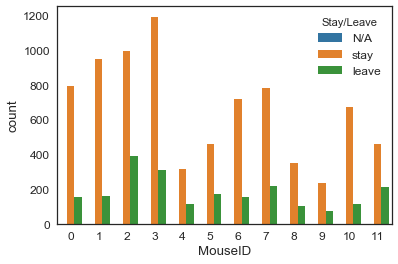

In [47]:
sns.countplot(data=df_DMS, x = 'MouseID', hue = 'Stay/Leave')



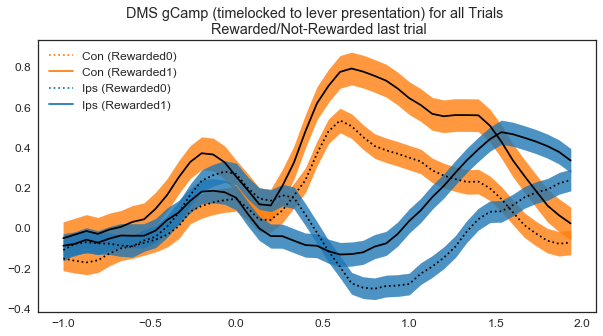

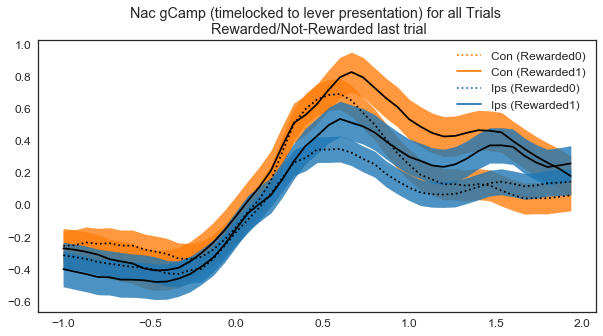

In [56]:
for df_src, src_name in zip([df_DMS, df_Nac], ['DMS', 'Nac']):
# for mouse in np.arange(NS):
#     df_src = df_DMS[df_DMS['MouseID'] == mouse]
#     src_name = 'DMS Mouse ' + str(mouse)

    figure = plt.figure(figsize = (10, 5))
    for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


        for r, r_st in zip([0, 1], [':', '-']):
            _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Stay/Leave'] == 'stay') & (df_src['Action'] == ch)]['g_np'])
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(_g_reward, axis = 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = r_st)
#             plt.ylim([-0.5, 2.0])

            plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
            plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
    plt.title(src_name + ' gCamp (timelocked to lever presentation) for all Trials \n Rewarded/Not-Rewarded last trial')

    plt.legend()


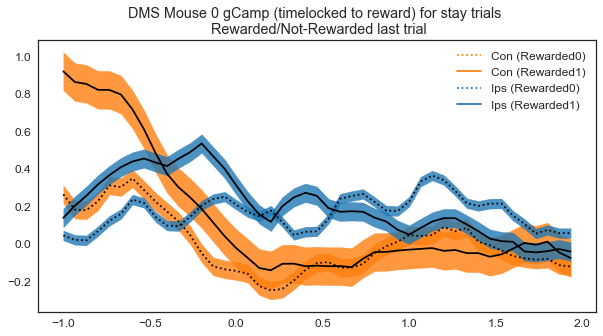

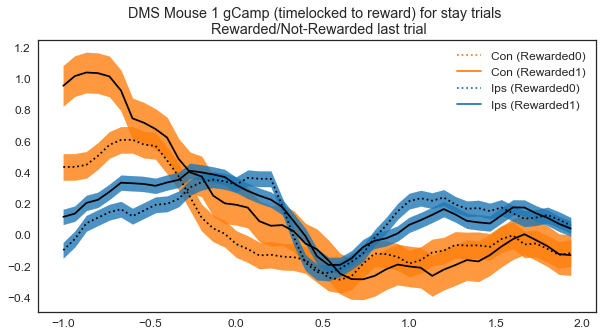

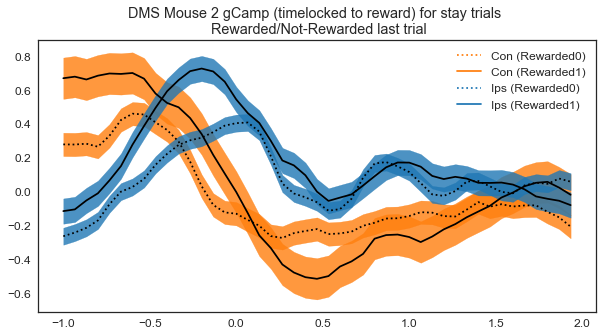

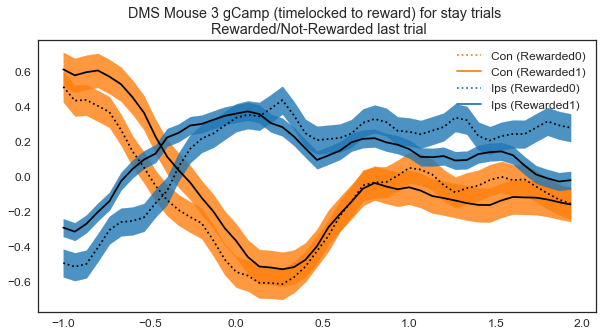

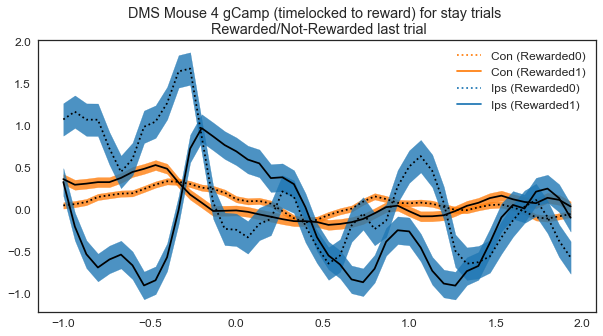

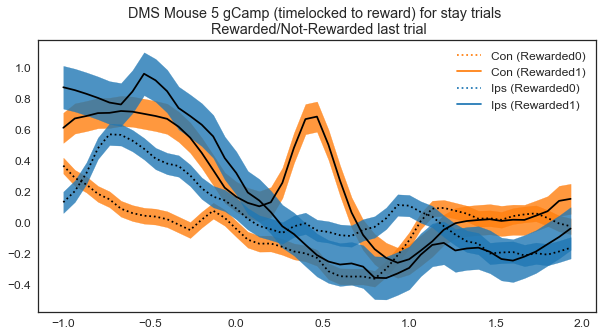

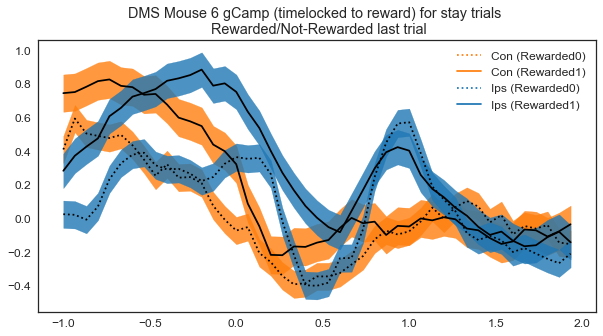

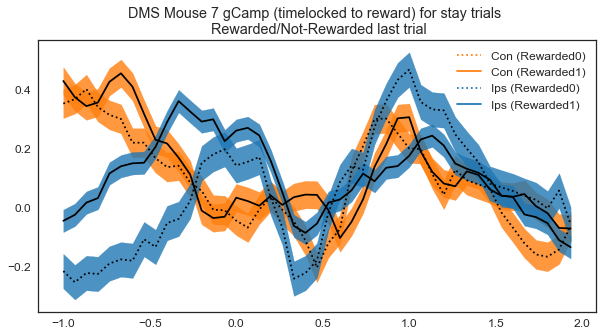

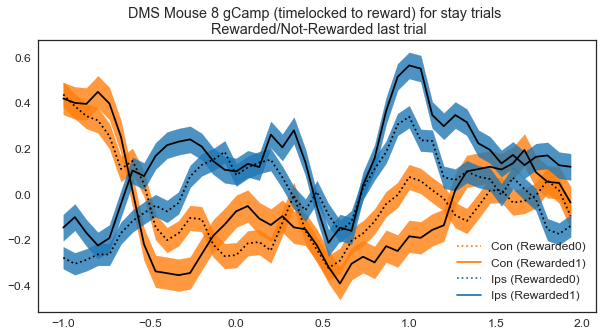

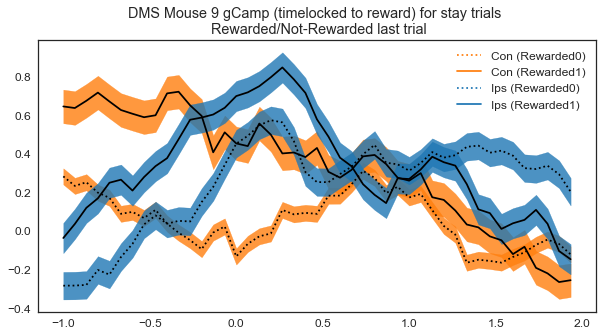

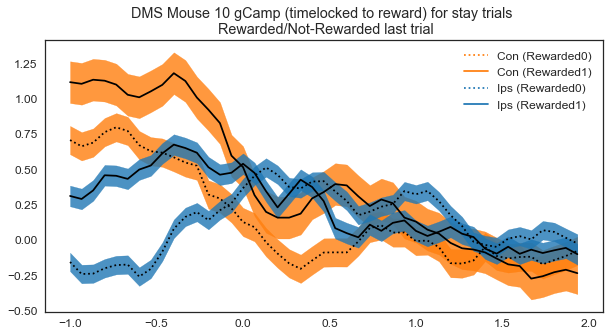

In [45]:
# for df_src, src_name in zip([df_DMS, df_Nac], ['DMS', 'Nac']):
for mouse in np.arange(NS):
    df_src = df_DMS[df_DMS['MouseID'] == mouse]
    src_name = 'DMS Mouse ' + str(mouse)
    sub = 'stay'
    figure = plt.figure(figsize = (10, 5))
    for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


        for r, r_st in zip([0, 1], [':', '-']):
            _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Stay/Leave'] == sub) & (df_src['Action'] == ch)]['g_reward'])
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(_g_reward, axis = 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = r_st)
#             plt.ylim([-0.5, 2.0])

            plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
            plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
    plt.title(src_name + ' gCamp (timelocked to reward) for ' + sub +  ' trials \n Rewarded/Not-Rewarded last trial')

    plt.legend()


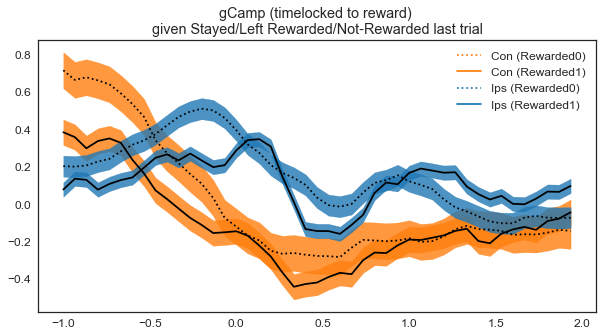

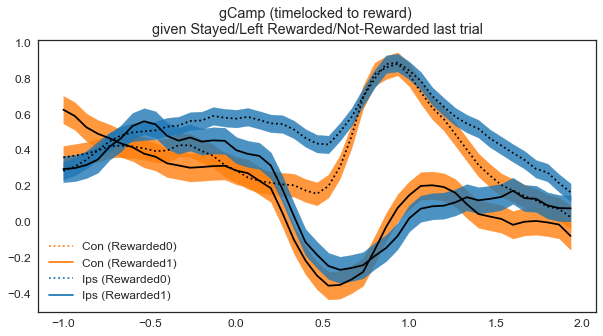

In [14]:
for df_src, color in zip([df_DMS, df_Nac], ['C0', 'C1']):

    figure = plt.figure(figsize = (10, 5))
    for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


        for r, r_st in zip([0, 1], [':', '-']):
            _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Stay/Leave'] == 'leave') & (df_src['Action'] == ch)]['g_reward'])
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(_g_reward, axis = 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = r_st)

            plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
            plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
    plt.title('gCamp (timelocked to reward) \ngiven Stayed/Left Rewarded/Not-Rewarded last trial')

    plt.legend()


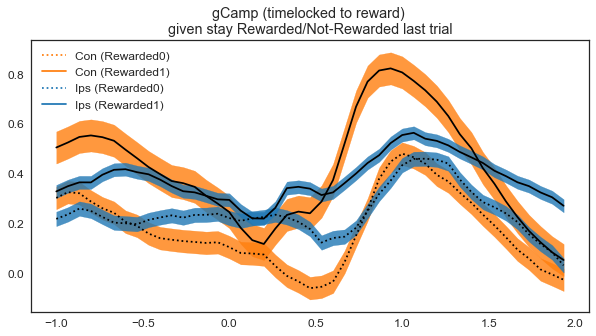

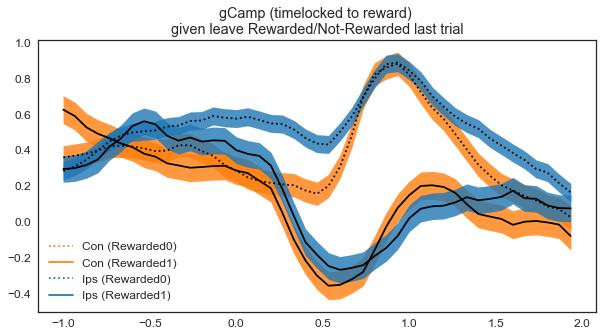

In [34]:
for choice_sl, color in zip(['stay', 'leave'], ['C0', 'C1']):
    df_src = df_Nac
    figure = plt.figure(figsize = (10, 5))
    for ch, ch_col in zip(['Con', 'Ips'], ['C1', 'C0']):


        for r, r_st in zip([0, 1], [':', '-']):
            _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Stay/Leave'] == choice_sl) & (df_src['Action'] == ch)]['g_reward'])
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(_g_reward, axis = 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = r_st)

            plt.fill_between(x, y-error, y+error, color = ch_col, alpha = 0.8)
            plt.plot([], color = ch_col, linestyle = r_st, label = ch + ' (Rewarded' + str(r) + ')')
    plt.title('gCamp (timelocked to reward) \ngiven ' + choice_sl + ' Rewarded/Not-Rewarded last trial')

    plt.legend()


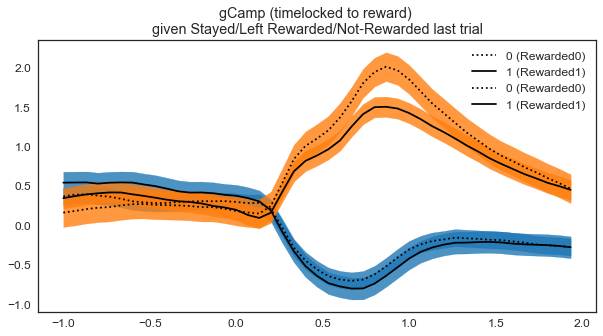

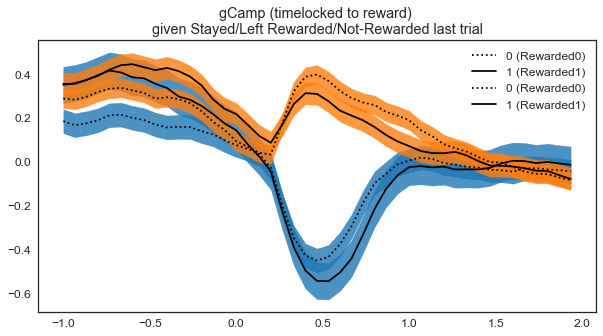

In [35]:
for df_src in [df_Nac, df_DMS]:


    figure = plt.figure(figsize = (10, 5))
    for r_now, ch_color in zip([0, 1], ['C0', 'C1']):


        for r, r_st in zip([0, 1], [':', '-']):
            _g_reward = np.vstack(df_src[(df_src['Reward_last'] == r) & (df_src['Reward'] == r_now)]['g_reward'])
            x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
            y = np.mean(_g_reward, axis = 0)
            error = np.std(y, axis = 0) / np.sqrt(NS)

            plt.plot(x, y, 'k', linestyle = r_st)

            plt.fill_between(x, y-error, y+error, color = ch_color, alpha = 0.8)
            plt.plot([], color = 'k', linestyle = r_st, label = str(r) + ' (Rewarded' + str(r) + ')')
    plt.title('gCamp (timelocked to reward) \ngiven Stayed/Left Rewarded/Not-Rewarded last trial')

    plt.legend()


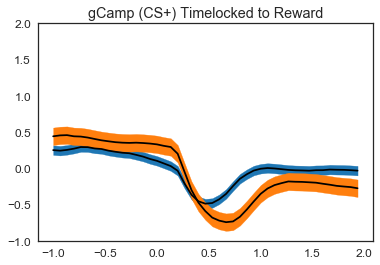

In [10]:
for df_src, color in zip([df_DMS, df_Nac], ['C0', 'C1']):

    _g_reward = np.vstack(df_src[df_src['Reward'] ==0]['g_reward'])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(_g_reward, axis = 0)
    error = np.std(y, axis = 0) / np.sqrt(NS)

    plt.plot(x, y, 'k-')
    plt.ylim([-1, 2])

    plt.fill_between(x, y-error, y+error, label = 'DMS', color = color)
    plt.title('gCamp (CS+) Timelocked to Reward')


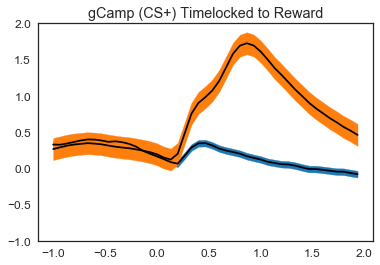

In [9]:
for df_src, color in zip([df_DMS, df_Nac], ['C0', 'C1']):

    _g_reward = np.vstack(df_src[df_src['Reward'] == 1]['g_reward'])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(_g_reward, axis = 0)
    error = np.std(y, axis = 0) / np.sqrt(NS)

    plt.plot(x, y, 'k-')
    plt.ylim([-1, 2])

    plt.fill_between(x, y-error, y+error, label = 'DMS', color = color)
    plt.title('gCamp (CS+) Timelocked to Reward')


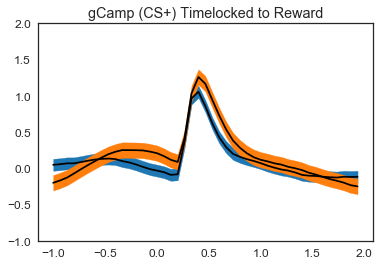

In [9]:
for df_src, color in zip([df_DMS, df_Nac], ['C0', 'C1']):

    _g_reward = np.vstack(df_src[df_src['Reward'] ==0]['g_lp'])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(_g_reward, axis = 0)
    error = np.std(y, axis = 0) / np.sqrt(NS)

    plt.plot(x, y, 'k-')
    plt.ylim([-1, 2])

    plt.fill_between(x, y-error, y+error, label = 'DMS', color = color)
    plt.title('gCamp (CS+) Timelocked to Reward')
